# Student Graduation Classification (Naive Bayes) — Streamlit-ready Pipeline

## Objective
Build a simple ML pipeline to classify student graduation status (`status_kelulusan`: 0 = Tidak Lulus, 1 = Lulus) using **Naive Bayes** and prepare artifacts for a **Streamlit** web app.

## Dataset
CSV columns:
- `ipk` (0–4)
- `sks_lulus` (credits completed)
- `kehadiran_persen` (0–100)
- `mk_mengulang` (number of repeated courses)
- `status_kelulusan` (target, 0/1)

## ML Steps
1. First Cleaning (no imputation/encoding yet)
2. Train/Test Split (stratified)
3. EDA (train only)
4. Preprocessing (Scaling only)
5. Modeling (Gaussian Naive Bayes) + baseline evaluation
6. Cross-Validation (Stratified K-Fold) — validation, not tuning
7. Final Evaluation (test set) + error analysis

## Outputs (Artifacts)
- `cleaned_dataset.csv`
- `X_train.csv`, `X_test.csv`, `y_train.csv`, `y_test.csv`
- `X_train_scaled.csv`, `X_test_scaled.csv`
- `scaler.joblib`
- `naive_bayes_model.joblib`

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc, RocCurveDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.feature_selection import mutual_info_classif

sns.set_style("whitegrid")

RANDOM_STATE = 42

# Files
RAW_CSV = "dataset_kelulusan_mahasiswa_lulus_tidak_lulus_300fiiiix.csv"
CLEAN_CSV = "cleaned_dataset.csv"

X_TRAIN_CSV = "X_train.csv"
X_TEST_CSV = "X_test.csv"
Y_TRAIN_CSV = "y_train.csv"
Y_TEST_CSV = "y_test.csv"

X_TRAIN_SCALED_CSV = "X_train_scaled.csv"
X_TEST_SCALED_CSV = "X_test_scaled.csv"

SCALER_PATH = "scaler.joblib"
MODEL_PATH = "naive_bayes_model.joblib"

FEATURES = ["ipk", "sks_lulus", "kehadiran_persen", "mk_mengulang"]
TARGET = "status_kelulusan"

print("Setup complete.")

Setup complete.


In [ ]:
def to_snake_case(cols):
    return [c.strip().lower().replace(" ", "_") for c in cols]

def print_class_distribution(y, name="dataset"):
    y = pd.Series(y).astype(int)
    counts = y.value_counts().sort_index()
    perc = (counts / len(y) * 100).round(2)
    dist = pd.DataFrame({"count": counts, "percent": perc.astype(str) + "%"})
    print(f"\nClass distribution ({name}):")
    display(dist)

def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues", cbar=False,
        xticklabels=["Pred 0 (Tidak Lulus)", "Pred 1 (Lulus)"],
        yticklabels=["True 0 (Tidak Lulus)", "True 1 (Lulus)"]
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="GaussianNB").plot(ax=plt.gca())
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()
    return roc_auc

def plot_precision_recall(y_true, y_proba, title="Precision-Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)

    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, lw=2, label=f"AP={ap:.3f}")
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return ap

## Step 1 — First Cleaning (No Imputation/Encoding)

**Goal:** Perform initial data checks and standardize column names.  
**Input:** raw CSV (`RAW_CSV`)  
**Output:** `cleaned_dataset.csv`  
**Notes:** No imputation/encoding at this step. We only validate ranges, check missing/duplicates, and ensure numeric types.

In [ ]:
df = pd.read_csv(RAW_CSV)
print("Original shape:", df.shape)
display(df.head())

# Standardize column names
df.columns = to_snake_case(df.columns)
print("\nColumns:", df.columns.tolist())

# Basic info
print("\nInfo:")
df.info()

print("\nDescribe:")
display(df.describe(include="all"))

# Quality checks
print("\nMissing values:")
missing = df.isna().sum()
display(missing[missing > 0] if (missing > 0).any() else "No missing values.")

dup_count = df.duplicated().sum()
print("\nDuplicated rows:", dup_count)

print("\nUnique values per column:")
display(df.nunique())

# Ensure numeric parsing (do not impute)
for c in FEATURES + [TARGET]:
    before_na = df[c].isna().sum()
    df[c] = pd.to_numeric(df[c], errors="coerce")
    after_na = df[c].isna().sum()
    if after_na > before_na:
        print(f"Warning: NaNs introduced in column '{c}' due to coercion: +{after_na - before_na}")

# Range validation (warnings only)
def warn_if_outside(series, low=None, high=None, name="col"):
    if low is not None and (series < low).any():
        print(f"Warning: {name} has values < {low}")
    if high is not None and (series > high).any():
        print(f"Warning: {name} has values > {high}")

warn_if_outside(df["ipk"], 0, 4, "ipk")
warn_if_outside(df["kehadiran_persen"], 0, 100, "kehadiran_persen")
warn_if_outside(df["sks_lulus"], 0, None, "sks_lulus")
warn_if_outside(df["mk_mengulang"], 0, None, "mk_mengulang")

if not set(df[TARGET].dropna().unique()).issubset({0, 1}):
    print("Warning: target contains values outside {0,1}")

# Save cleaned dataset
df.to_csv(CLEAN_CSV, index=False)
print(f"\nSaved cleaned dataset to: {CLEAN_CSV}")

Original shape: (300, 5)


,IPK,SKS_Lulus,Kehadiran_Persen,MK_Mengulang,Status_Kelulusan
0,3.37,126,91.1,0,1
1,3.15,120,77.6,3,1
2,3.43,144,92.0,0,1
3,3.73,144,95.8,3,1
4,3.12,124,88.3,2,1



Columns: ['ipk', 'sks_lulus', 'kehadiran_persen', 'mk_mengulang', 'status_kelulusan']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ipk               300 non-null    float64
 1   sks_lulus         300 non-null    int64  
 2   kehadiran_persen  300 non-null    float64
 3   mk_mengulang      300 non-null    int64  
 4   status_kelulusan  300 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 11.8 KB

Describe:


,ipk,sks_lulus,kehadiran_persen,mk_mengulang,status_kelulusan
count,300.000000,300.000000,300.000000,300.000000,300.000000
mean,3.195400,126.990000,85.539667,1.233333,0.663333
std,0.336704,12.101987,7.715241,1.068970,0.473359
min,2.070000,110.000000,63.400000,0.000000,0.000000
25%,2.960000,115.750000,80.400000,0.000000,0.000000
50%,3.220000,127.000000,85.300000,1.000000,1.000000
75%,3.420000,138.000000,90.700000,2.000000,1.000000
max,4.000000,144.000000,100.000000,5.000000,1.000000



Missing values:


'No missing values.'


Duplicated rows: 0

Unique values per column:


,0
ipk,121
sks_lulus,35
kehadiran_persen,180
mk_mengulang,6
status_kelulusan,2



Saved cleaned dataset to: cleaned_dataset.csv


## Step 2 — Train/Test Split (Stratified)

**Goal:** Split data into train/test while preserving target distribution.  
**Input:** `cleaned_dataset.csv`  
**Output:** `X_train.csv`, `X_test.csv`, `y_train.csv`, `y_test.csv`  
**Notes:** Use `stratify=y` to avoid skewed class distribution.

In [ ]:
df = pd.read_csv(CLEAN_CSV)

X = df[FEATURES].copy()
y = df[TARGET].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

print_class_distribution(y, "full")
print_class_distribution(y_train, "train")
print_class_distribution(y_test, "test")

X_train.to_csv(X_TRAIN_CSV, index=False)
X_test.to_csv(X_TEST_CSV, index=False)
y_train.to_frame(TARGET).to_csv(Y_TRAIN_CSV, index=False)
y_test.to_frame(TARGET).to_csv(Y_TEST_CSV, index=False)

print("\nSaved split CSV files.")

Shapes:
X_train: (240, 4) X_test: (60, 4)
y_train: (240,) y_test: (60,)

Class distribution (full):


,count,percent
status_kelulusan,,
0,101,33.67%
1,199,66.33%



Class distribution (train):


,count,percent
status_kelulusan,,
0,81,33.75%
1,159,66.25%



Class distribution (test):


,count,percent
status_kelulusan,,
0,20,33.33%
1,40,66.67%



Saved split CSV files.


## Step 3 — EDA (Train Set Only)

**Goal:** Explore feature distributions and relationship with the target.  
**Input:** `X_train.csv`, `y_train.csv`  
**Output:** Visual insights + feature ranking (EDA-based).  
**Notes:** EDA is done on training data only to reduce bias/leakage.

Train df shape: (240, 5)


,ipk,sks_lulus,kehadiran_persen,mk_mengulang,status_kelulusan
0,2.90,132,84.4,2,1
1,3.17,129,83.0,1,1
2,3.03,122,85.7,1,1
3,3.52,139,80.6,0,1
4,3.56,142,100.0,1,1



Class distribution (train):


,count,percent
status_kelulusan,,
0,81,33.75%
1,159,66.25%


/tmp/ipython-input-4123595610.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=TARGET, data=train_df, palette="viridis")


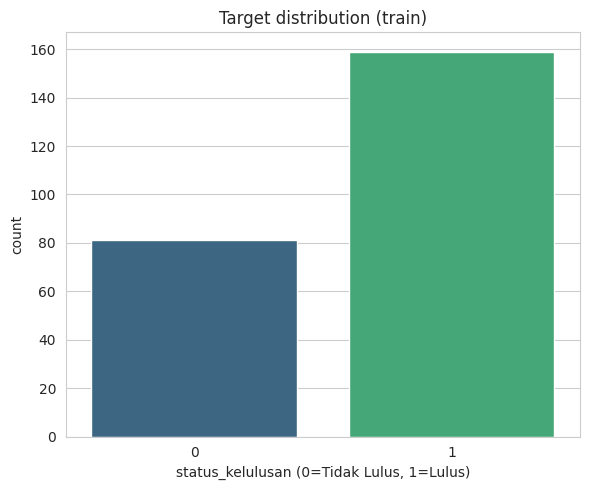

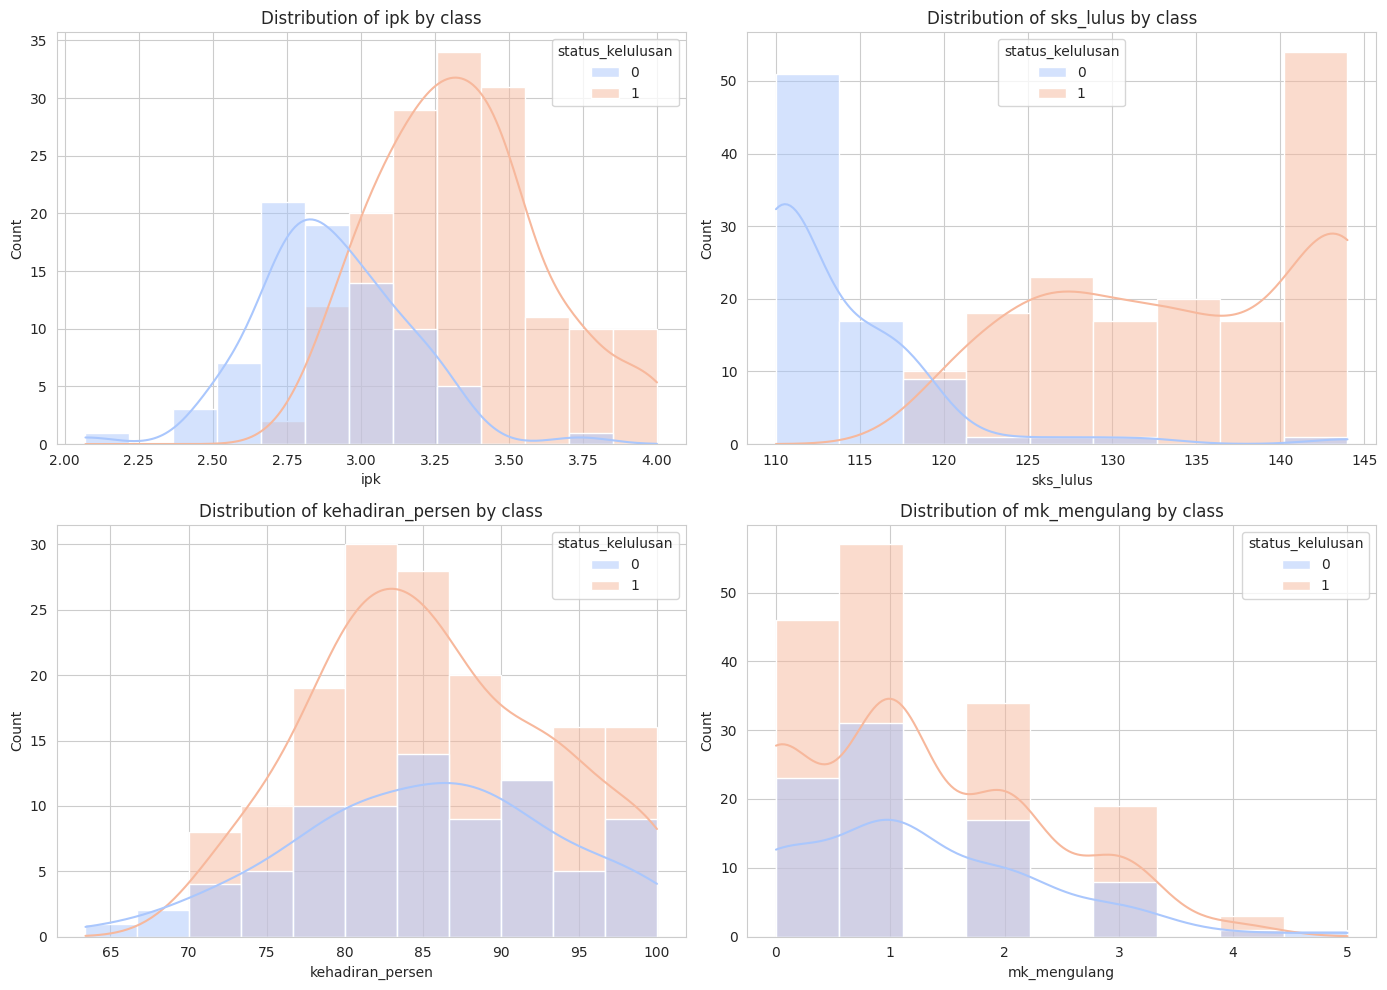

/tmp/ipython-input-4123595610.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x=TARGET, y=f, ax=ax, palette="muted")
/tmp/ipython-input-4123595610.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x=TARGET, y=f, ax=ax, palette="muted")
/tmp/ipython-input-4123595610.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x=TARGET, y=f, ax=ax, palette="muted")
/tmp/ipython-input-4123595610.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.

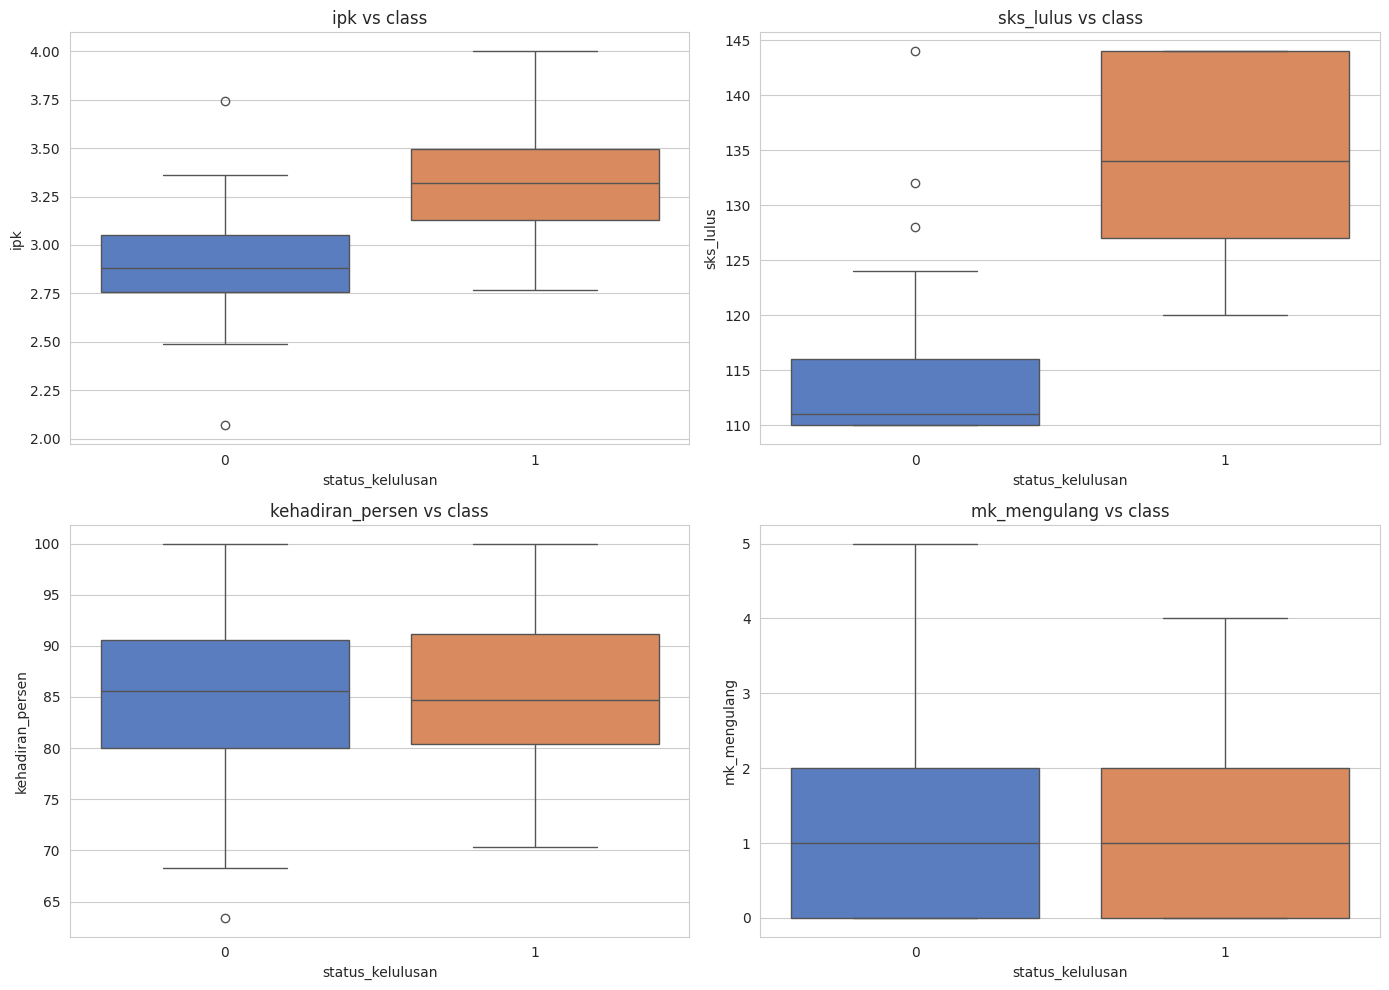

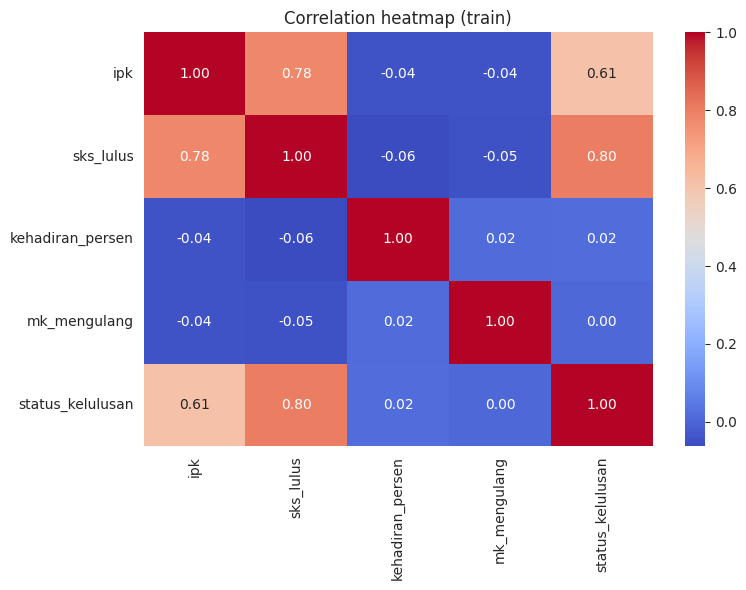

/tmp/ipython-input-4123595610.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_diff.values, y=mean_diff.index, palette="Blues_r")


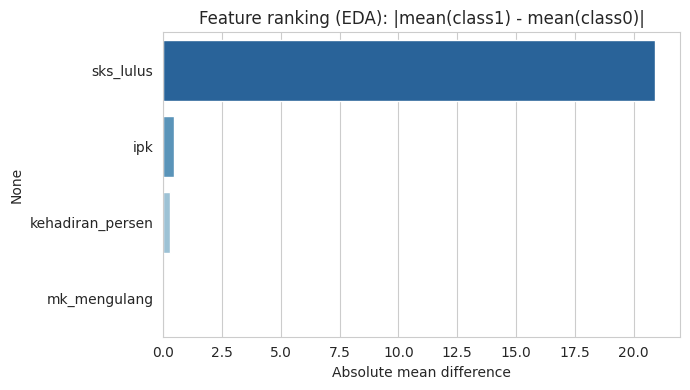

/tmp/ipython-input-4123595610.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_s.values, y=mi_s.index, palette="Oranges_r")


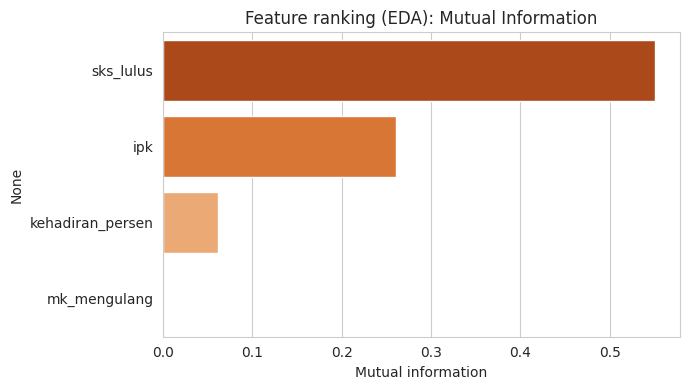


Group stats (mean/median):


ipk          sks_lulus        kehadiran_persen         \
                      mean median        mean median             mean median   
status_kelulusan                                                               
0                 2.897284   2.88  113.444444  111.0        85.313580   85.6   
1                 3.339434   3.32  134.364780  134.0        85.583648   84.7   

                 mk_mengulang         
                         mean median  
status_kelulusan                      
0                    1.209877    1.0  
1                    1.220126    1.0

In [ ]:
X_train = pd.read_csv(X_TRAIN_CSV)
y_train = pd.read_csv(Y_TRAIN_CSV)[TARGET].astype(int)
train_df = pd.concat([X_train, y_train.rename(TARGET)], axis=1)

print("Train df shape:", train_df.shape)
display(train_df.head())
print_class_distribution(train_df[TARGET], "train")

# Countplot
plt.figure(figsize=(6, 5))
sns.countplot(x=TARGET, data=train_df, palette="viridis")
plt.title("Target distribution (train)")
plt.xlabel("status_kelulusan (0=Tidak Lulus, 1=Lulus)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Hist + KDE by class
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
for ax, f in zip(axes, FEATURES):
    sns.histplot(data=train_df, x=f, hue=TARGET, kde=True, ax=ax, palette="coolwarm")
    ax.set_title(f"Distribution of {f} by class")
plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
for ax, f in zip(axes, FEATURES):
    sns.boxplot(data=train_df, x=TARGET, y=f, ax=ax, palette="muted")
    ax.set_title(f"{f} vs class")
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(train_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation heatmap (train)")
plt.tight_layout()
plt.show()

# Feature ranking (EDA-based)
# Mean diff
mean_diff = (
    train_df.groupby(TARGET)[FEATURES].mean().diff().iloc[-1].abs().sort_values(ascending=False)
)
plt.figure(figsize=(7, 4))
sns.barplot(x=mean_diff.values, y=mean_diff.index, palette="Blues_r")
plt.title("Feature ranking (EDA): |mean(class1) - mean(class0)|")
plt.xlabel("Absolute mean difference")
plt.tight_layout()
plt.show()

# Mutual information
mi = mutual_info_classif(train_df[FEATURES], train_df[TARGET], random_state=RANDOM_STATE)
mi_s = pd.Series(mi, index=FEATURES).sort_values(ascending=False)
plt.figure(figsize=(7, 4))
sns.barplot(x=mi_s.values, y=mi_s.index, palette="Oranges_r")
plt.title("Feature ranking (EDA): Mutual Information")
plt.xlabel("Mutual information")
plt.tight_layout()
plt.show()

print("\nGroup stats (mean/median):")
display(train_df.groupby(TARGET)[FEATURES].agg(["mean", "median"]))

## Step 4 — Preprocessing (Scaling Only)

**Goal:** Scale features to comparable ranges using StandardScaler.  
**Input:** `X_train.csv`, `X_test.csv`  
**Output:** `X_train_scaled.csv`, `X_test_scaled.csv`, `scaler.joblib`  
**Notes:** Fit scaler only on train, then transform train and test (avoid leakage).

In [ ]:
X_train = pd.read_csv(X_TRAIN_CSV)
X_test = pd.read_csv(X_TEST_CSV)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=FEATURES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=FEATURES)

print("Scaled train mean (approx 0):")
display(X_train_scaled_df.mean())

print("Scaled train std (approx 1):")
display(X_train_scaled_df.std())

X_train_scaled_df.to_csv(X_TRAIN_SCALED_CSV, index=False)
X_test_scaled_df.to_csv(X_TEST_SCALED_CSV, index=False)
joblib.dump(scaler, SCALER_PATH)

print(f"\nSaved: {X_TRAIN_SCALED_CSV}, {X_TEST_SCALED_CSV}, {SCALER_PATH}")

Scaled train mean (approx 0):


,0
ipk,7.401487e-16
sks_lulus,5.310567e-16
kehadiran_persen,-8.511710e-16
mk_mengulang,9.066821e-17


Scaled train std (approx 1):


,0
ipk,1.00209
sks_lulus,1.00209
kehadiran_persen,1.00209
mk_mengulang,1.00209



Saved: X_train_scaled.csv, X_test_scaled.csv, scaler.joblib


## Step 5 — Modeling (Gaussian Naive Bayes)

**Goal:** Train GaussianNB and evaluate on the test set (baseline).  
**Input:** `X_train_scaled.csv`, `X_test_scaled.csv`, `y_train.csv`, `y_test.csv`  
**Output:** `naive_bayes_model.joblib` + baseline metrics and plots.

Test Accuracy: 0.9833333333333333

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.98      1.00      0.99        40

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



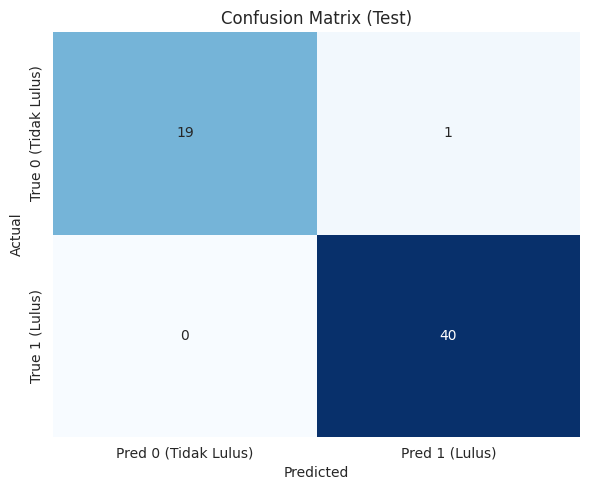

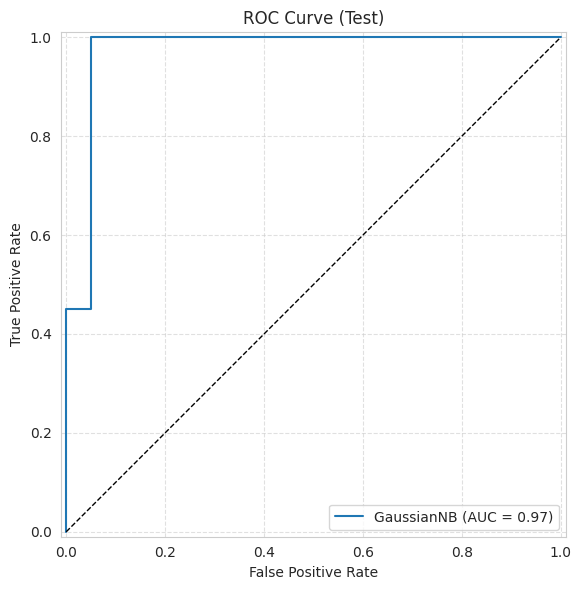

ROC-AUC: 0.9724999999999999

Saved model to: naive_bayes_model.joblib


In [ ]:
X_train = pd.read_csv(X_TRAIN_SCALED_CSV)
X_test = pd.read_csv(X_TEST_SCALED_CSV)
y_train = pd.read_csv(Y_TRAIN_CSV)[TARGET].astype(int)
y_test = pd.read_csv(Y_TEST_CSV)[TARGET].astype(int)

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "Confusion Matrix (Test)")

if y_proba is not None:
    roc_auc = plot_roc(y_test, y_proba, "ROC Curve (Test)")
    print("ROC-AUC:", roc_auc)

joblib.dump(model, MODEL_PATH)
print(f"\nSaved model to: {MODEL_PATH}")

## Step 6 — Cross-Validation (Stratified K-Fold)

**Goal:** Validate model stability using cross-validation on training set.  
**Input:** `X_train_scaled.csv`, `y_train.csv`  
**Output:** Mean ± std metrics across folds, plus ROC visualization.  
**Notes:** This step does NOT use the test set and does not tune hyperparameters.

In [ ]:
X_train = pd.read_csv(X_TRAIN_SCALED_CSV)
y_train = pd.read_csv(Y_TRAIN_CSV)[TARGET].astype(int)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "accuracy": "accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
}

model = GaussianNB()

cv_results = cross_validate(
    model, X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)

summary = []
for k, v in cv_results.items():
    if k.startswith("test_"):
        metric = k.replace("test_", "")
        summary.append((metric, np.mean(v), np.std(v)))

summary_df = pd.DataFrame(summary, columns=["metric", "mean", "std"]).sort_values("metric")
summary_df["mean ± std"] = summary_df["mean"].map(lambda x: f"{x:.4f}") + " ± " + summary_df["std"].map(lambda x: f"{x:.4f}")
display(summary_df[["metric", "mean ± std"]])

,metric,mean ± std
0,accuracy,0.9333 ± 0.0243
3,f1,0.9471 ± 0.0213
1,precision,0.9820 ± 0.0237
2,recall,0.9179 ± 0.0586
4,roc_auc,0.9820 ± 0.0274


## Step 7 — Final Evaluation (Test Set) + Error Analysis

**Goal:** Produce final evaluation plots and identify misclassifications for interpretation.  
**Input:** `X_test_scaled.csv`, `y_test.csv`, `naive_bayes_model.joblib`  
**Output:** Final plots (Confusion Matrix, ROC, PR curve, probability separation) + error analysis table.

Final Test Accuracy: 0.9833333333333333

Final Classification report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.98      1.00      0.99        40

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



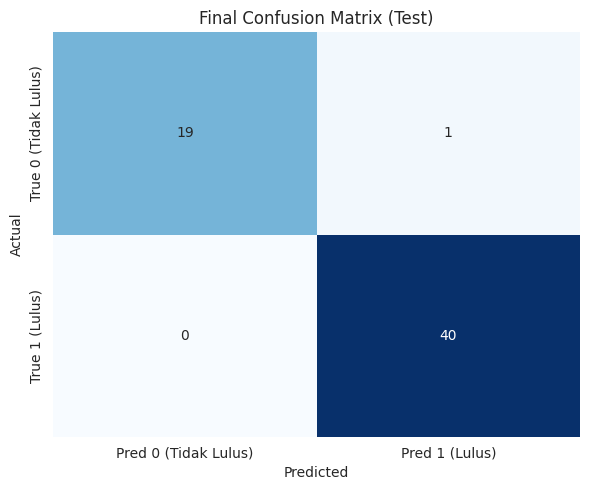

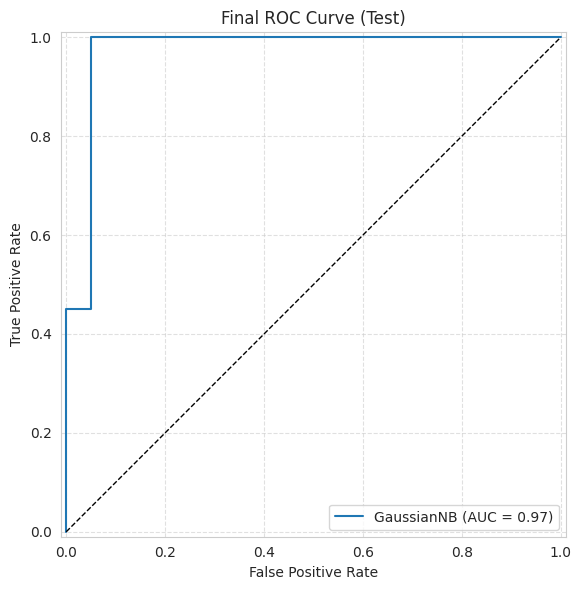

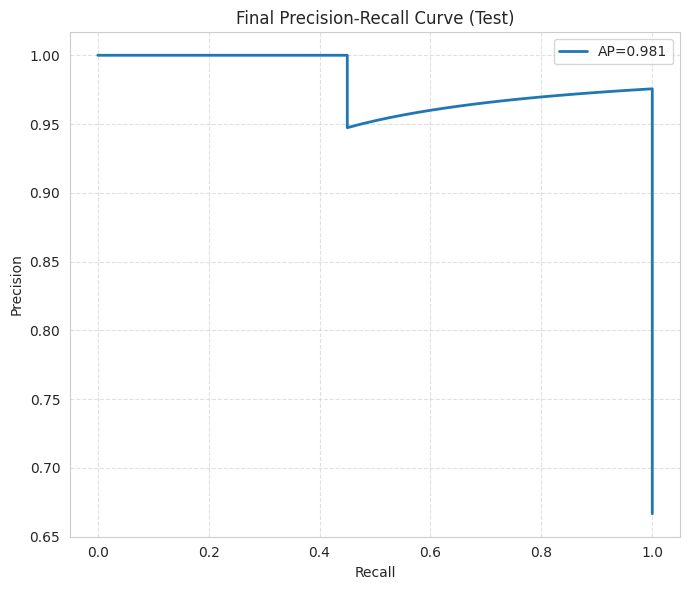

Final ROC-AUC: 0.9724999999999999
Average Precision: 0.9811201593576218


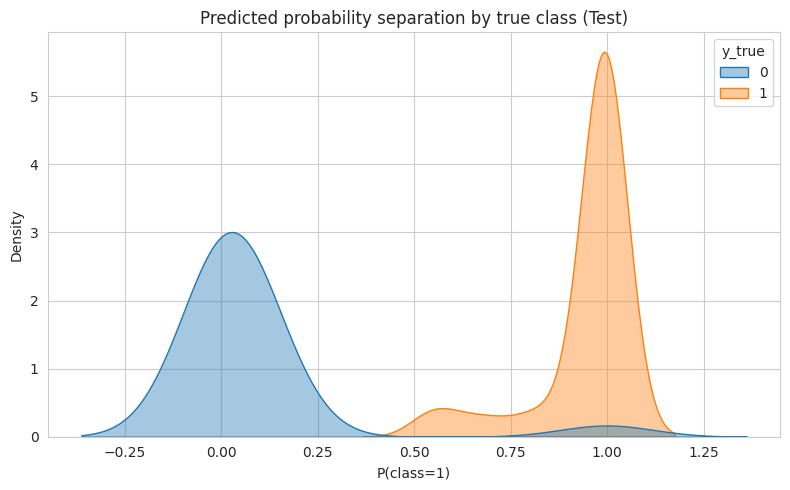


Misclassified samples (up to 10):


,ipk,sks_lulus,kehadiran_persen,mk_mengulang,y_true,y_pred,p_class1,confidence
25,0.408598,0.543187,-2.786855,0.740272,0,1,0.999695,0.999695


In [ ]:
X_test = pd.read_csv(X_TEST_SCALED_CSV)
y_test = pd.read_csv(Y_TEST_CSV)[TARGET].astype(int)

model = joblib.load(MODEL_PATH)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

print("Final Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nFinal Classification report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, "Final Confusion Matrix (Test)")

if y_proba is not None:
    roc_auc = plot_roc(y_test, y_proba, "Final ROC Curve (Test)")
    ap = plot_precision_recall(y_test, y_proba, "Final Precision-Recall Curve (Test)")
    print("Final ROC-AUC:", roc_auc)
    print("Average Precision:", ap)

    # Probability separation plot
    prob_df = pd.DataFrame({"y_true": y_test.values, "y_proba": y_proba})
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=prob_df, x="y_proba", hue="y_true", fill=True, common_norm=False, alpha=0.4)
    plt.title("Predicted probability separation by true class (Test)")
    plt.xlabel("P(class=1)")
    plt.tight_layout()
    plt.show()

# Error analysis table (top confident wrong predictions)
result_df = X_test.copy()
result_df["y_true"] = y_test.values
result_df["y_pred"] = y_pred
if y_proba is not None:
    result_df["p_class1"] = y_proba

wrong = result_df[result_df["y_true"] != result_df["y_pred"]].copy()
if not wrong.empty and y_proba is not None:
    wrong["confidence"] = np.where(wrong["y_pred"] == 1, wrong["p_class1"], 1 - wrong["p_class1"])
    wrong = wrong.sort_values("confidence", ascending=False)

print("\nMisclassified samples (up to 10):")
display(wrong.head(10))